# Pyspark TensorFlow Inference

## Text classification
Based on: https://www.tensorflow.org/tutorials/keras/text_classification

In [1]:
import os
import re
import shutil
import string

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses

In [2]:
print(tf.__version__)

2.12.0


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1", url, untar=True, cache_dir=".", cache_subdir=""
)

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

In [4]:
os.listdir(dataset_dir)

['imdbEr.txt', 'imdb.vocab', 'train', 'test', 'README']

In [5]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'unsupBow.feat',
 'unsup',
 'urls_pos.txt',
 'urls_neg.txt',
 'labeledBow.feat',
 'pos']

In [6]:
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [13]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [23]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 5s 7ms/step - loss: 0.6665 - binary_accuracy: 0.6916 - val_loss: 0.6180 - val_binary_accuracy: 0.7692
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5513 - binary_accuracy: 0.7996 - val_loss: 0.5002 - val_binary_accuracy: 0.8218
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4465 - binary_accuracy: 0.8445 - val_loss: 0.4211 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3794 - binary_accuracy: 0.8663 - val_loss: 0.3745 - val_binary_accuracy: 0.8594
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3362 - binary_accuracy: 0.8773 - val_loss: 0.3453 - val_binary_accuracy: 0.8666
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3059 - binary_accuracy: 0.8877 - val_loss: 0.3261 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 4s 7ms/ste

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 3s 3ms/step - loss: 0.3107 - binary_accuracy: 0.8729
Loss:  0.31073614954948425
Accuracy:  0.8728799819946289


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

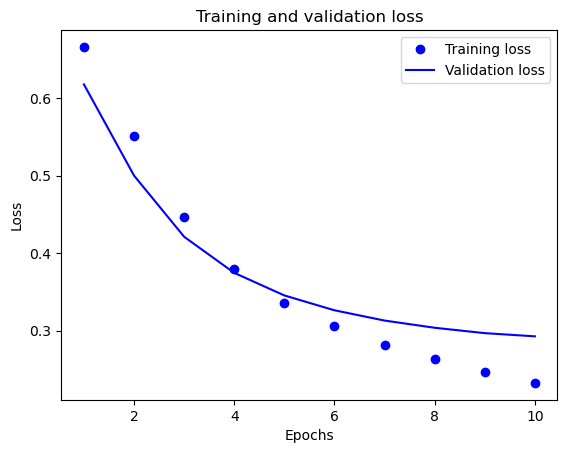

In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

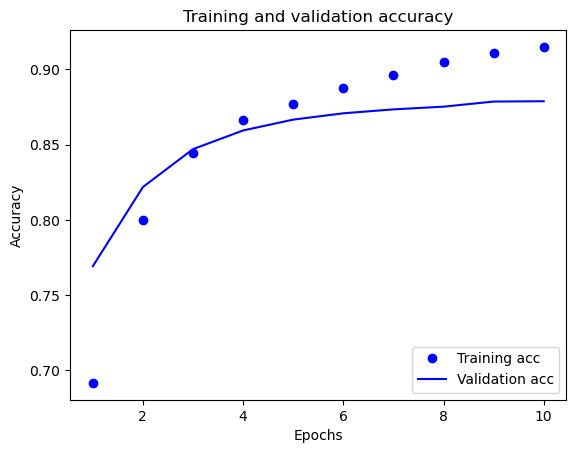

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [29]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3107 - accuracy: 0.8729
0.8728799819946289


In [30]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 98ms/step


array([[0.59665436],
       [0.417315  ],
       [0.33598474]], dtype=float32)

### Save Model

In [31]:
!rm -rf text_model

In [32]:
export_model.save('text_model')

INFO:tensorflow:Assets written to: text_model/assets


INFO:tensorflow:Assets written to: text_model/assets


### Inspect saved model

In [33]:
!tree text_model

text_model
├── assets
├── fingerprint.pb
├── keras_metadata.pb
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00001
    └── variables.index

2 directories, 5 files


In [34]:
!saved_model_cli show --dir text_model --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['text_vectorization_input'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_text_vectorization_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['activation'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


### Load model

In [35]:
# register callables as custom objects before loading
custom_objects = {"vectorize_layer": vectorize_layer, "custom_standardization": custom_standardization}
with tf.keras.utils.custom_object_scope(custom_objects):
    new_model = tf.keras.models.load_model('text_model')

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 sequential (Sequential)     (None, 1)                 160033    
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Predict

In [36]:
new_model.predict(examples)

1/1 [==============================] - 0s 108ms/step


array([[0.59665436],
       [0.417315  ],
       [0.33598474]], dtype=float32)

## PySpark

## Inference using Spark DL API
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [37]:
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col
from pyspark.sql.types import ArrayType, FloatType, DoubleType

In [38]:
# note: using huggingface IMDB parquet dataset
df = spark.read.parquet("/home/leey/devpub/leewyang/sparkext/examples/huggingface/imdb_test")

In [39]:
df.show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                               lines|
+----------------------------------------------------------------------------------------------------+
|Everyone I know loves this movie, but I am afraid that I don't. I hated this film so much that I ...|
|New Year's Day. The day after consuming a few too many vodka martinis and Cosmopolitans mixed wit...|
|I've come to realise through watching this sort of film that I don't like them very much. Caged W...|
|I'm one of those gluttons for punishment when it comes to sitcoms these days-I still will check t...|
|This must be one of the most annoying, arrogant, poser films I've ever seen. What a waste of budg...|
|I received this movie in a pack called "50 all-star Movies" for $18 (45 cents each). Many are goo...|
|This movie earns its 3 for lousy writing, poor technical merit and conti

In [40]:
def predict_batch_fn():
    # since this function runs on the executor, any required imports should be added inside the function.
    import re
    import string
    import tensorflow as tf
    from tensorflow.keras import layers

    def custom_standardization(input_data):
        lowercase = tf.strings.lower(input_data)
        stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
        return tf.strings.regex_replace(
            stripped_html, "[%s]" % re.escape(string.punctuation), ""
        )

    max_features = 10000
    sequence_length = 250

    vectorize_layer = layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length,
    )

    custom_objects = {"vectorize_layer": vectorize_layer,
                      "custom_standardization": custom_standardization}
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_model(
            "/home/leey/devpub/leewyang/sparkext/examples/tensorflow/text_model")

    def predict(inputs):
        return model.predict(inputs)

    return predict

In [41]:
classify = predict_batch_udf(predict_batch_fn,
                             return_type=FloatType(),
                             batch_size=256)

In [42]:
%%time
predictions = df.withColumn("preds", classify(struct("lines")))
results = predictions.collect()

CPU times: user 319 ms, sys: 45.8 ms, total: 364 ms
Wall time: 15.4 s


In [43]:
%%time
predictions = df.withColumn("preds", classify("lines"))
results = predictions.collect()

CPU times: user 105 ms, sys: 35.2 ms, total: 140 ms
Wall time: 11.6 s


In [44]:
%%time
predictions = df.withColumn("preds", classify(col("lines")))
results = predictions.collect()

CPU times: user 298 ms, sys: 2.06 ms, total: 300 ms
Wall time: 11.6 s


In [45]:
predictions.show(truncate=80)

+--------------------------------------------------------------------------------+-------------+
|                                                                           lines|        preds|
+--------------------------------------------------------------------------------+-------------+
|Everyone I know loves this movie, but I am afraid that I don't. I hated this ...|  0.004348396|
|New Year's Day. The day after consuming a few too many vodka martinis and Cos...|   0.34742248|
|I've come to realise through watching this sort of film that I don't like the...|  0.015905242|
|I'm one of those gluttons for punishment when it comes to sitcoms these days-...| 0.0035548473|
|This must be one of the most annoying, arrogant, poser films I've ever seen. ...|1.08720524E-4|
|I received this movie in a pack called "50 all-star Movies" for $18 (45 cents...|   0.19590223|
|This movie earns its 3 for lousy writing, poor technical merit and continuity...|  0.045021966|
|I am a fan of his ... This mo

### Using Triton Server

For optimal performance., you should use a Triton inference server image that is compatible with the TensorFlow version used to train the model, per the [Framework Containers Support Matrix](https://docs.nvidia.com/deeplearning/frameworks/support-matrix/index.html)

For demonstration purposes, this notebook just uses the [Python backend with a custom execution environment](https://github.com/triton-inference-server/python_backend#creating-custom-execution-environments), using a conda-pack environment created as follows:
```
conda create -n tf-gpu -c conda-forge python=3.8
conda activate tf-gpu
pip install tensorflow
pip install conda-pack
conda pack  

cp tf-gpu.tar.gz ../models_tf
```

In [46]:
import numpy as np

from functools import partial
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct
from pyspark.sql.types import ArrayType, FloatType
from typing import Union, Dict

In [47]:
# note: using huggingface IMDB parquet for now, since conversion above isn't working
df = spark.read.parquet("/home/leey/devpub/leewyang/sparkext/examples/huggingface/imdb_test").repartition(1)

In [48]:
columns = df.columns
columns

['lines']

In [49]:
df.show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                               lines|
+----------------------------------------------------------------------------------------------------+
|Everyone I know loves this movie, but I am afraid that I don't. I hated this film so much that I ...|
|New Year's Day. The day after consuming a few too many vodka martinis and Cosmopolitans mixed wit...|
|I've come to realise through watching this sort of film that I don't like them very much. Caged W...|
|I'm one of those gluttons for punishment when it comes to sitcoms these days-I still will check t...|
|This must be one of the most annoying, arrogant, poser films I've ever seen. What a waste of budg...|
|I received this movie in a pack called "50 all-star Movies" for $18 (45 cents each). Many are goo...|
|This movie earns its 3 for lousy writing, poor technical merit and conti

#### Start Triton Server on each executor

In [50]:
num_executors = 1

nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:22.07-py3", "tritonserver --model-repository=/models",
            "nvcr.io/nvidia/tritonserver:23.03-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="128M",
            volumes={
                "/home/leey/devpub/leewyang/sparkext/examples/models_tf": {"bind": "/models", "mode": "ro"},
                "/home/leey/devpub/leewyang/sparkext/examples/tensorflow/text_model": {"bind": "/text_model", "mode": "ro"},
                "/home/leey/devpub/leewyang/sparkext/examples/tensorflow/my_pet_classifier": {"bind": "/my_pet_classifier", "mode": "ro"}
            }
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.mapPartitions(start_triton).collect()

[True]

#### Run inference

In [51]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool8),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))
        
        response = client.infer(model_name, inputs=request)
        
        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)
        
    return predict

In [52]:
# need to pass the list of columns into the model_udf
classify = predict_batch_udf(partial(triton_fn, triton_uri="localhost:8001", model_name="text_classification"),
                             input_tensor_shapes=[[1]],
                             return_type=FloatType(),
                             batch_size=2048)

In [53]:
%%time
df.withColumn("preds", classify(struct(*columns))).show(truncate=80)

+--------------------------------------------------------------------------------+------------+
|                                                                           lines|       preds|
+--------------------------------------------------------------------------------+------------+
|Everyone I know loves this movie, but I am afraid that I don't. I hated this ...|0.0043483935|
|New Year's Day. The day after consuming a few too many vodka martinis and Cos...|   0.3474225|
|I've come to realise through watching this sort of film that I don't like the...| 0.015905242|
|I'm one of those gluttons for punishment when it comes to sitcoms these days-...|0.0035548478|
|This must be one of the most annoying, arrogant, poser films I've ever seen. ...|1.0872031E-4|
|I received this movie in a pack called "50 all-star Movies" for $18 (45 cents...|  0.19590206|
|This movie earns its 3 for lousy writing, poor technical merit and continuity...|  0.04502197|
|I am a fan of his ... This movie sucked

In [54]:
%%time
df.withColumn("preds", classify(*columns)).show(truncate=80)

+--------------------------------------------------------------------------------+------------+
|                                                                           lines|       preds|
+--------------------------------------------------------------------------------+------------+
|Everyone I know loves this movie, but I am afraid that I don't. I hated this ...|0.0043483935|
|New Year's Day. The day after consuming a few too many vodka martinis and Cos...|   0.3474225|
|I've come to realise through watching this sort of film that I don't like the...| 0.015905242|
|I'm one of those gluttons for punishment when it comes to sitcoms these days-...|0.0035548478|
|This must be one of the most annoying, arrogant, poser films I've ever seen. ...|1.0872031E-4|
|I received this movie in a pack called "50 all-star Movies" for $18 (45 cents...|  0.19590206|
|This movie earns its 3 for lousy writing, poor technical merit and continuity...|  0.04502197|
|I am a fan of his ... This movie sucked

#### Stop Triton Server on each executor

In [55]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.mapPartitions(stop_triton).collect()

[True]

In [56]:
spark.stop()